In [1]:
pip install -U textblob

Requirement already up-to-date: textblob in f:\software\anaconda3\lib\site-packages (0.15.3)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
nltk.download('wordnet')
data = pd.read_csv('text_emotion.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
data = data.drop('author', axis=1)
data

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [4]:
#Dropping rows with other emotion labels

data  = data.drop(data[data.sentiment == 'anger'].index)
data  = data.drop(data[data.sentiment == 'boredom'].index)
data  = data.drop(data[data.sentiment == 'enthusiasm'].index)
data  = data.drop(data[data.sentiment == 'empty'].index)
data  = data.drop(data[data.sentiment == 'fun'].index)
data  = data.drop(data[data.sentiment == 'relief'].index)
data  = data.drop(data[data.sentiment == 'surprise'].index)
data  = data.drop(data[data.sentiment == 'love'].index)
data  = data.drop(data[data.sentiment == 'hate'].index)
data  = data.drop(data[data.sentiment == 'neutral'].index)
data  = data.drop(data[data.sentiment == 'worry'].index)

In [5]:
#Making all letters lowercase
data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#Removing Punctuation, Symbols
data['content'] = data['content'].str.replace('[^\w\s]',' ')

#Removing Stop Words using NLTK
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [6]:
# Code to find the top 10,000 rarest words (modify according to your dataset) 
# appearing in the data
freq = pd.Series(' '.join(data['content']).split()).value_counts()[-10000:]

# Removing all those rarely appearing words from the data
freq = list(freq.index)
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [7]:
#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
from sklearn import preprocessing
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)

# Splitting into training and testing data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)
X_train

array(['vestacaro already get tax money helio winning pole position ha ha',
       'please please anyone', 'good morning everbody', ..., 'oh yes',
       'posting late got back seeing star trek awesome',
       'sad otalia today'], dtype=object)

In [8]:
# Extracting TF-IDF parameters
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.fit_transform(X_val)

In [9]:
# Extracting Count Vectors Parameters
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data['content'])
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

# Models using the TF-IDF features

## Model 1: Multinomial Naive Bayes Classifier

In [10]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.naive_bayes import MultinomialNB
accuracy=[]
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

naive bayes tfidf accuracy 0.5385356454720617


array([[277, 244],
       [235, 282]], dtype=int64)

## Model 2: Linear SVM

In [11]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred = lsvm.predict(X_val_tfidf)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('svm using tfidf accuracy %s' %accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

svm using tfidf accuracy 0.5452793834296724


array([[235, 286],
       [186, 331]], dtype=int64)

## Model 3: logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_val_tfidf)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('log reg tfidf accuracy %s' % accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

log reg tfidf accuracy 0.5317919075144508


F:\software\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[259, 262],
       [224, 293]], dtype=int64)

## Model 4: Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_val_tfidf)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('randon forest tfidf accuracy %s' % accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

randon forest tfidf accuracy 0.5240847784200385


array([[297, 224],
       [270, 247]], dtype=int64)

# Models using count vectors features

## Model 1: Multinomial Naive Bayes Classifier

In [14]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_count, y_train)
y_pred = nb.predict(X_val_count)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('naive bayes count vectors accuracy %s' % accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

naive bayes count vectors accuracy 0.7678227360308285


array([[401, 120],
       [121, 396]], dtype=int64)

## Model 2: Linear SVM

In [15]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_count, y_train)
y_pred = lsvm.predict(X_val_count)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

lsvm using count vectors accuracy 0.7976878612716763


array([[429,  92],
       [118, 399]], dtype=int64)

## Model 3: Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_count, y_train)
y_pred = logreg.predict(X_val_count)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

log reg count vectors accuracy 0.7832369942196532


F:\software\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[421, 100],
       [125, 392]], dtype=int64)

## Model 4: Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_count, y_train)
y_pred = rf.predict(X_val_count)
accuracy.append(accuracy_score(y_pred, y_val)*100)
print('random forest with count vectors accuracy %s' % accuracy_score(y_pred, y_val))
confusion_matrix(y_val, y_pred)

random forest with count vectors accuracy 0.7591522157996147


array([[409, 112],
       [138, 379]], dtype=int64)

# Graph based analysis

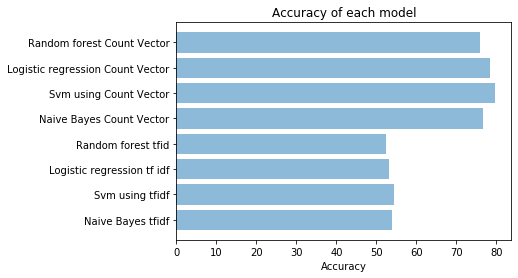

In [18]:
objects = ('Naive Bayes tfidf', 'Svm using tfidf', 
           'Logistic regression tf idf', 'Random forest tfid', 
           'Naive Bayes Count Vector', 'Svm using Count Vector', 
           'Logistic regression Count Vector', 'Random forest Count Vector')
y_pos = np.arange(len (objects)) 
plt.barh(y_pos, accuracy, align='center', alpha=0.5)
plt.yticks (y_pos, objects)
plt.xlabel('Accuracy') 
plt.title('Accuracy of each model')

plt.show()

# REALITY CHECK

In [19]:
tweets = pd.DataFrame(['I am very happy today! The atmosphere looks cheerful',
'Things are looking great. It was such a good day',
'Success is right around the corner. Lets celebrate this victory',
'Everything is more beautiful when you experience them with a smile!',
'Now this is my worst, okay? But I am gonna get better.',
'I am tired, boss. Tired of being on the road, lonely as a sparrow in the rain. I am tired of all the pain I feel',
'This is quite depressing. I am filled with sorrow',
'His death broke my heart. It was a sad day'])

# Doing some preprocessing on these tweets as done before
tweets[0] = tweets[0].str.replace('[^\w\s]',' ')
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets[0] = tweets[0].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
from textblob import Word
tweets[0] = tweets[0].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Extracting Count Vectors feature from our tweets
tweet_count = count_vect.transform(tweets[0])

#Predicting the emotion of the tweet using our already trained linear SVM
tweet_pred = lsvm.predict(tweet_count)

print(tweet_pred)

[0 0 0 0 1 1 1 1]
